In [56]:
import yaml
import itertools
import plotly.express as px
import pandas as pd
from itertools import islice
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np

class Configuration():
    configPath = 'settings.yaml'
    
    def __init__(self, dimension, dataset):
        with open(self.configPath, "r") as f:
            self.data = yaml.safe_load(f)
        self.d = self.data.get('dimensions')
        self.options = list(self.d.values())
        self.query = self.data.get('query')
        self.sd = dimension
        self.size = dataset
    
    def join_tuple_string(strings_tuple) -> str:
        return '.'.join(strings_tuple)
        
    def file_reader(self):
        tuple = list(itertools.product(*self.options))
        joined_string = map(Configuration.join_tuple_string, tuple)
        joined_string = list(joined_string)
        
        avg = []
        for i in joined_string:
            df = pd.read_csv(f'./log/{self.size}/{i}.txt', sep = ',', header = None)
            df = df.fillna(0)
            mean = df.mean(axis=0)
            avg.append(mean)
            
        df = pd.DataFrame(avg, index = joined_string)
        df = df.set_axis(["Q"+str(i+1) for i in range(self.query)], axis = 1)
        df = df.fillna(5000)
        
        if self.sd != list(self.d.keys())[-1]:
            li = []
            config = list(df.index)
            d_list = list(self.d)
            key_slice = list(islice(d_list, d_list.index(self.sd)+1, None))
            number_of_options = [self.d[x]for x in key_slice]
            total_length = len(list(itertools.product(*number_of_options)))
            
            for counter in range(total_length):
                for x in range (int(len(config)/total_length)): 
                    li.append(config[counter])
                    counter = counter+total_length
            df = df.reindex(index = li)
        return df
    
class SDRank(Configuration):
    def __init__(self, config):
        self.data = config.data
        self.d = config.d
        self.options = config.options
        self.query = config.query
        # Configuration.sd
        # Configuration.size 
    
    def calculateRankScore():
        print(config.data)
        

<AxesSubplot:title={'center':'csv'}>

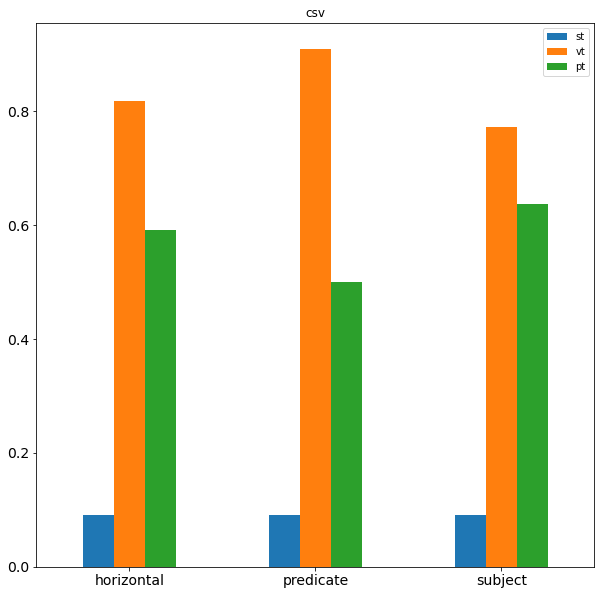

In [3]:
from PAPyA.Rank import *

config = "D:\coding\RDF_BenchRankingLib\settings.yaml"
logs = "D:\coding\RDF_BenchRankingLib\log"
schemaSDRank = SDRank(config, logs, '250M', 'schemas')
schemaSDRank.plot('csv')

In [6]:
from abc import ABC, abstractmethod
import yaml
import itertools
import plotly.express as px
import pandas as pd
from itertools import islice
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np

class Configuration():
    def loader(filepath):
        with open(filepath, "r") as f:
            data = yaml.safe_load(f)
        return data
    
class SDRank():
    def join_tuple_string(strings_tuple) -> str:
        return '.'.join(strings_tuple)
    
    def file_reader(sd:str, size, filepath):
        global joined_string
        global df
        
        data = Configuration.loader(filepath)
        d = data.get('dimensions')
        options = list(d.values())

        tuple = list(itertools.product(*options))
        joined_string = map(SDRank.join_tuple_string, tuple)
        joined_string = list(joined_string)
        
        avg = []
        for i in joined_string:
            df = pd.read_csv(f'./log/{size}/{i}.txt', sep = ',', header = None)
            df = df.fillna(0)
            mean = df.mean(axis=0)
            avg.append(mean)

        df = pd.DataFrame(avg, index = joined_string)
        df = df.set_axis(["Q"+str(i+1) for i in range(data.get('query'))], axis = 1)
        df = df.fillna(5000)
        
        if sd != list(d.keys())[-1]:
            li = []
            config = list(df.index)
            d_list = list(d)
            key_slice = list(islice(d_list, d_list.index(sd)+1, None))
            number_of_options = [d[x]for x in key_slice]
            total_length = len(list(itertools.product(*number_of_options)))
            
            for counter in range(total_length):
                for x in range (int(len(config)/total_length)): 
                    li.append(config[counter])
                    counter = counter+total_length
            df = df.reindex(index = li)
        return df
    
    def calculateRankScore(sd:str, size, filepath):
        global rank_dataframe_rscore
        
        data = Configuration.loader(filepath)
        df = SDRank.file_reader(sd, size, filepath)
        d = data.get('dimensions')
        # split dataframe according to SD
        Dictionary = {}
        count = 0
        loop = len(d.get(sd))
        dfs = []
        
        for i in range(int(len(joined_string)/len(d.get(sd)))):
            Dictionary['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(d.get(sd))
            dfs.append(Dictionary[f'df_{i}'])
        
        rank_dataframe = []
        # create rank occurences
        for x in dfs:
            df_ranks = x.T
            column_names = df_ranks.columns.to_numpy().tolist()
            
            df_ranks_occurences = []
            for index, row in df_ranks.iterrows():
                df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

            df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

            df_transpose = df_ranks_occurences.transpose()

            rank_table = []
            for index, row in df_transpose.iterrows():
                result_row = np.zeros(len(df_transpose.index))
                for i in range(len(row)):
                    result_row[int(row[i])-1] +=1
                rank_table.append(result_row)

            rank_table = pd.DataFrame(rank_table)
            rank_table = rank_table.set_axis(column_names, axis = 'index')
            rank_table = rank_table.set_axis(['Rank '+str(i+1) for i in range(len(column_names))], axis='columns')
            
            # CREATE R SCORE
            q = data.get('query')
            d = len(rank_table.index)

            rank_score = []
            for index, row in rank_table.iterrows():
                s=0
                for r in range(d):  
                    s = s + (row[r]*(d-(r+1)) / (q*(d-1)) )
                rank_score.append(s)
            rank_score = pd.DataFrame(rank_score)
            rank_score = rank_score.set_axis(column_names, axis = 'index')
            rank_score = rank_score.set_axis(['Result'], axis='columns')
            rank_score = pd.concat([rank_table, rank_score], axis = 1)
            rank_dataframe.append(rank_score)
        rank_dataframe_rscore = pd.concat(rank_dataframe)
        return rank_dataframe_rscore.sort_values(by = ['Result'], ascending = False)
    
    def plot(dimension:str,size:str, option:str):
        SDRank.calculateRankScore(dimension, size, 'settings.yaml')
        data = Configuration.loader('settings.yaml')
        d = data.get('dimensions')
        options = list(d.values())
        dims = list(d.keys())
        
        if len(dims) > 3:
            raise Exception("too much dimensions")

        if dimension == dims[0]:
            if option not in options[0]:
                filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{option}\b', regex = True)]

                if option in options[1]:
                    Dictionary = {}
                    loop = len(options[0])
                    count = 0
                    for i in options[2]:
                        Dictionary['{}'.format(i)] = filter[count:loop]
                        count = loop
                        loop = loop+len(options[0])
                    
                    key = list(Dictionary)
                    Dictionary2 = {}
                    
                    for j in range(len(options[2])):
                        val = list(Dictionary[key[j]]['Result'])
                        Dictionary2['val{}'.format(j)] = val
                    
                    data = np.vstack(list(Dictionary2.values()))
                    df2 = pd.DataFrame(data = data, index = list(Dictionary.keys()), columns = options[0])
                    return df2.plot.bar(title = str(option), rot = 0, fontsize = 14, figsize = (10,10))
                
                elif option in options[2]:
                    Dictionary = {}
                    loop = len(options[0])
                    count = 0
                    for i in options[1]:
                        Dictionary['{}'.format(i)] = filter[count:loop]
                        count = loop
                        loop = loop+len(options[0])
                        
                    key = list(Dictionary)
                    Dictionary2 = {}
                    
                    for j in range(len(options[1])):
                        val = list(Dictionary[key[j]]['Result'])
                        Dictionary2['val{}'.format(j)] = val
                    
                    data = np.vstack(list(Dictionary2.values()))
                    df2 = pd.DataFrame(data = data, index = list(Dictionary.keys()), columns = options[0])
                    return df2.plot.bar(title = str(option), rot=0, fontsize = 14, figsize = (10,10))
            else:
                return 'the dimension is ' + dims[0]

        elif dimension == dims[1]:
            if option not in options[1]:
                filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{option}\b', regex = True)]

                if option in options[2]:
                    Dictionary = {}
                    loop = len(options[1])
                    count = 0
                    for i in options[0]:
                        Dictionary['{}'.format(i)] = filter[count:loop]
                        count = loop
                        loop = loop+len(options[1])
                    
                    key = list(Dictionary)
                    Dictionary2 = {}
                    
                    for j in range(len(options[0])):
                        val = list(Dictionary[key[j]]['Result'])
                        Dictionary2['val{}'.format(j)] = val
                    
                    data = np.vstack(list(Dictionary2.values()))
                    df2 = pd.DataFrame(data = data, index = list(Dictionary.keys()), columns = options[1])
                    return df2.plot.bar(title = str(option), rot = 0, fontsize = 14, figsize = (10,10))
                
                elif option in options[0]:
                    Dictionary = {}
                    loop = len(options[1])
                    count = 0
                    for i in options[2]:
                        Dictionary['{}'.format(i)] = filter[count:loop]
                        count = loop
                        loop = loop+len(options[1])
                        
                    key = list(Dictionary)
                    Dictionary2 = {}
                    
                    for j in range(len(options[2])):
                        val = list(Dictionary[key[j]]['Result'])
                        Dictionary2['val{}'.format(j)] = val
                    
                    data = np.vstack(list(Dictionary2.values()))
                    df2 = pd.DataFrame(data = data, index = list(Dictionary.keys()), columns = options[1])
                    return df2.plot.bar(title = str(option), rot=0, fontsize = 14, figsize = (10,10))
            else:
                return 'the dimension is ' + dims[1]
                    
        elif dimension == dims[2]:
            if option not in options[2]:
                filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{option}\b', regex = True)]

                if option in options[0]:
                    Dictionary = {}
                    loop = len(options[2])
                    count = 0
                    for i in options[1]:
                        Dictionary['{}'.format(i)] = filter[count:loop]
                        count = loop
                        loop = loop+len(options[2])
                    
                    key = list(Dictionary)
                    Dictionary2 = {}
                    
                    for j in range(len(options[1])):
                        val = list(Dictionary[key[j]]['Result'])
                        Dictionary2['val{}'.format(j)] = val
                    
                    data = np.vstack(list(Dictionary2.values()))
                    df2 = pd.DataFrame(data = data, index = list(Dictionary.keys()), columns = options[2])
                    return df2.plot.bar(title = str(option), rot = 0, fontsize = 14, figsize = (10,10))
                
                elif option in options[1]:
                    Dictionary = {}
                    loop = len(options[2])
                    count = 0
                    for i in options[0]:
                        Dictionary['{}'.format(i)] = filter[count:loop]
                        count = loop
                        loop = loop+len(options[2])
                        
                    key = list(Dictionary)
                    Dictionary2 = {}
                    
                    for j in range(len(options[0])):
                        val = list(Dictionary[key[j]]['Result'])
                        Dictionary2['val{}'.format(j)] = val
                    
                    data = np.vstack(list(Dictionary2.values()))
                    df2 = pd.DataFrame(data = data, index = list(Dictionary.keys()), columns = options[2])
                    return df2.plot.bar(title = str(option), rot=0, fontsize = 14, figsize = (10,10))
            else:
                return 'the dimension is ' + dims[2]
    def plotRadar(sd:str, size:str):
        import warnings
        warnings.simplefilter(action='ignore', category=FutureWarning)

        data = Configuration.loader('settings.yaml')
        d = data.get('dimensions')
        options = list(d.values())
        dims = list(d.keys())
        
        if len(dims) > 3:
            raise Exception("too much dimensions")

        topConfig = SDRank.calculateRankScore(sd, size, 'settings.yaml')['Result'].index.str.replace('.', ' ', regex=False)
        topConfig = topConfig[0].split()

        x = topConfig[0]
        y = topConfig[1]
        z = topConfig[2]

        res = []
        for i in dims:
            SDRank.calculateRankScore(i, size, 'settings.yaml')
            r = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{x}\b)(?=.*\b{y}\b)(?=.*\b{z}\b)', regex=True)]['Result']
            res.append(r[0])

        df = pd.DataFrame(dict(r=res, theta=topConfig))
        fig = px.line_polar(df, r='r', theta='theta', line_close=True)
        return fig.show()

class MDRankPareto():
    # NON-DOMINATED SORTING ALGORITHM 
    def nsga2(inputPoints, dominates):
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr] # masuk row pertama
            inputPoints.remove(candidateRow) # buang row pertamanya
            rowNr = 0
            nonDominated = True # row kandidat yg baru masuk di set true buat non dominated nya
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr] # ambil row lanjutannya
                if dominates(candidateRow, row): # ngecek row kandidat ama row lanjutan di input_point dominasinya
                    # If it is worse on all features remove the row from the array
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif dominates(row, candidateRow):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                # add the non-dominated point to the Pareto frontier
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints
    
    def dominates(row, candidateRow):
        return np.sum([row[x] <= candidateRow[x] for x in range(len(row))]) == len(row)# kalo lebih kecil semua berarti dominasi
    def dominates_agg(row, candidateRow):
        return np.sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)
        
    def getConfs(points,orignaldf):
        point_confs = {}
        for i in range(0, len(orignaldf)):
            for val in points:
                if (list(val)==np.array(orignaldf[i][1:], dtype=np.float64).tolist()):
                    point_confs[val]=orignaldf[i][0]
        return point_confs

    def getConfsSorted(confsDict):  
        # # summing all the values using sum()
        temp1 = {val: sum(float(idx) for idx in val) 
                    for val, key in confsDict.items()} #sum the ranks of non dominated solution
                
        # using sorted to perform sorting as required
        temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]],reverse=False) #sort according to the sum before
        res={}
        for key, val in temp2:
            res[key]=confsDict[key]
        return res
    
    def plot(size, filepath):
        MDRankPareto.paretoAgg(size, filepath)
        
        if len(dims) > 3:
            raise Exception("too much dimensions")
        
        fig = plt.figure()
        fig.set_size_inches(15, 15)
        ax = fig.add_subplot(111, projection='3d')
        dp = np.array(list(dominatedPoints))
        pp = np.array(list(paretoPoints))

        print(pp.shape,dp.shape)
        ax.scatter(dp[:,0],dp[:,1],dp[:,2])
        ax.scatter(pp[:,0],pp[:,1],pp[:,2],color='green')

        ax.set_xlabel('Rf')
        ax.set_ylabel('Rp')
        ax.set_zlabel('Rs')
        
        import matplotlib.tri as mtri
        triang = mtri.Triangulation(pp[:,0],pp[:,1])
        ax.plot_trisurf(triang,pp[:,2],color='green',alpha=0.3)
        plt.show()
    
    def paretoQ(size, filepath):
        data = Configuration.loader(filepath)
        d = data.get('dimensions')
        
        dimensionsAll = Ranker.getRanks(sd = list(d.keys())[-1], size=size, filepath=filepath)
        dimensionsAll = dimensionsAll.reset_index().values
        dimensions = np.array(Ranker.getRanks(sd = list(d.keys())[-1], size=size, filepath=filepath)[:], dtype = np.float64)
        inputPoints = dimensions.tolist()
        paretoPoints, dominatedPoints = MDRankPareto.nsga2(inputPoints, MDRankPareto.dominates)
        
        pareto_q = MDRankPareto.getConfs(paretoPoints, dimensionsAll)
        pareto_q = MDRankPareto.getConfsSorted(pareto_q)

        vals = np.array(list(pareto_q.values()))
        table_pareto = pd.DataFrame({'Solution': vals}, columns=['Solution'])

        dominated=  MDRankPareto.getConfs(dominatedPoints, dimensionsAll)
        dominated = MDRankPareto.getConfsSorted(dominated)
        vals = np.array(list(dominated.values()))
        table_dominated = pd.DataFrame({'Dominated': vals}, columns=['Dominated'])

        table = pd.concat([table_pareto, table_dominated], axis = 1)
        table = table.replace(np.nan, '', regex=True)
        return table
    
    def paretoAgg(size, filepath):
        global dims
        global paretoPoints
        global dominatedPoints
        
        data = Configuration.loader('settings.yaml')
        d = data.get('dimensions')
        dims = list(d.keys())

        li = []

        for x in dims:
            dimension_ranking = SDRank.calculateRankScore(x, size, filepath)
            dimension_ranking = dimension_ranking['Result']
            li.append(dimension_ranking)
        new_df = pd.concat(li, axis = 1)
        dimensionsAll = new_df.reset_index().values
        dimensions = np.array(dimensionsAll[:,1:], dtype = np.float64)
        inputPoints = dimensions.tolist()
        paretoPoints, dominatedPoints = MDRankPareto.nsga2(inputPoints, MDRankPareto.dominates_agg)

        pareto_agg = MDRankPareto.getConfs(paretoPoints, dimensionsAll)
        pareto_agg = MDRankPareto.getConfsSorted(pareto_agg)
        vals = np.array(list(pareto_agg.values()))
        table_pareto = pd.DataFrame(vals, columns=['Solution'])

        dominated = MDRankPareto.getConfs(dominatedPoints, dimensionsAll)
        dominated = MDRankPareto.getConfsSorted(dominated)
        vals = np.array(list(dominated.values()))
        table_dominated = pd.DataFrame({'Dominated': vals}, columns=['Dominated'])
        
        table = pd.concat([table_pareto, table_dominated], axis = 1)
        table = table.replace(np.nan, '', regex=True)
        return table
    
class Ranker():
    def getRanks(sd, size, filepath):
        df = SDRank.file_reader(sd, size, filepath)
        df_transpose = df.T
        df_full_ranks = []
        for index, row in df_transpose.iterrows():
            df_full_ranks.append(ss.rankdata(row, method = 'max'))
        df_full_ranks = pd.DataFrame(df_full_ranks)
        df_full_ranks = df_full_ranks.T
        df_full_ranks = df_full_ranks.set_axis(df_transpose.columns, axis = 'index') #configurations  
        df_full_ranks = df_full_ranks.set_axis([i+1 for i in range(len(df_transpose.index))], axis='columns') #query
        
        return df_full_ranks
    
    def bestofSD(sd,size,filepath,k):
        df = SDRank.calculateRankScore(sd,size,filepath)
        df = df['Result']
        df = df.nlargest(k)
        return df.index.to_numpy().tolist()
    
    def bestofParetoQ(size, filepath, k):
        df = MDRankPareto.paretoQ(size, filepath)
        df = list(df['Solution'])[:k]
        return df
    
    def bestofParetoAgg(size, filepath, k):
        df = MDRankPareto.paretoAgg(size, filepath)
        df = list(df['Solution'])[:k]
        return df
    
    def normalised_kendall_tau_distance(values1, values2):
        """Compute the Kendall tau distance."""
        n = len(values1)
        assert len(values2) == n, "Both lists have to be of equal length"
        i, j = np.meshgrid(np.arange(n), np.arange(n))
        a = np.argsort(values1)
        b = np.argsort(values2)
        ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
        return ndisordered / (n * (n - 1))
    
    def conformance(conformanceList,size, filepath, k:int, h:int):
        data = Configuration.loader('settings.yaml')
        d = data.get('dimensions')
        q = data.get('query')
        # list(d.keys())[-1]
        dims = list(d.keys())

        data = []
        idx = []
        for x in conformanceList:
            if x in dims:
                criteria_table = Ranker.getRanks(x, size, filepath).loc[Ranker.bestofSD(x,size,filepath,k)]
                criteria_table = criteria_table[criteria_table>h]
                count = criteria_table.count(axis = 1)
                sum = count.sum(axis=0)
                conformance = 1 - (sum/(k*q))
                data.append(conformance)
                idx.append(x)
            elif x == 'paretoQ':
                criteria_table_paretoQ = Ranker.getRanks(sd = list(d.keys())[-1], size=size, filepath=filepath).loc[Ranker.bestofParetoQ(size, filepath, k)]
                criteria_table_paretoQ = criteria_table_paretoQ[criteria_table_paretoQ>h]
                count = criteria_table_paretoQ.count(axis = 1)
                sum = count.sum(axis=0)
                conformance = 1 - (sum/(k*q))
                data.append(conformance)
                idx.append('paretoQ')
            elif x == 'paretoAgg':
                criteria_table_paretoAgg = Ranker.getRanks(sd = list(d.keys())[-1], size=size, filepath=filepath).loc[Ranker.bestofParetoAgg(size, filepath, k)]
                criteria_table_paretoAgg = criteria_table_paretoAgg[criteria_table_paretoAgg>h]
                count = criteria_table_paretoAgg.count(axis = 1)
                sum = count.sum(axis=0)
                conformance = 1 - (sum/(k*q))
                data.append(conformance)
                idx.append('paretoAgg')
                
        table = pd.DataFrame(data, index = idx, columns = [size])
        return table
    
    def coherence(coherenceList, rankset1, rankset2):
        data = Configuration.loader('settings.yaml')
        d = data.get('dimensions')
        q = data.get('query')
        # list(d.keys())[-1]
        dims = list(d.keys())
        
        result = []
        for x in coherenceList:
            if x in dims:
                var1 = SDRank.calculateRankScore(x, rankset1, 'settings.yaml')
                var1 = var1['Result'].sort_index()
                var1 = var1.to_numpy()
                
                var2 = SDRank.calculateRankScore(x, rankset2, 'settings.yaml')
                var2 = var2['Result'].sort_index()
                var2 = var2.to_numpy()
                
                kendall = Ranker.normalised_kendall_tau_distance(var1, var2)
                result.append(kendall)
            
            elif x == 'paretoAgg':
                var1 = SDRank.calculateRankScore(list(d.keys())[-1], rankset1, 'settings.yaml')
                paretoAggSolution = MDRankPareto.paretoAgg(rankset1, 'settings.yaml')
                paretoAggSolution = paretoAggSolution['Solution'].replace('', np.nan)
                paretoAggSolution = paretoAggSolution.dropna()
                var1 = var1.loc[paretoAggSolution]
                var1 = var1['Result']

                var2 = SDRank.calculateRankScore(list(d.keys())[-1], rankset2, 'settings.yaml')
                paretoAggSolution = MDRankPareto.paretoAgg(rankset2, 'settings.yaml')
                paretoAggSolution = paretoAggSolution['Solution'].replace('', np.nan)
                paretoAggSolution = paretoAggSolution.dropna()
                var2 = var2.loc[paretoAggSolution]
                var2 = var2['Result']

                newDf = pd.concat([var1, var2], axis = 1)
                newDf_column_name = newDf.columns.values
                newDf_column_name[0] = str(rankset1) #var1
                newDf_column_name[1] = str(rankset2) #var2

                newDf.columns = newDf_column_name
                newDf = newDf.fillna(1)
                var1 = newDf[str(rankset1)]
                var2 = newDf[str(rankset2)]
                
                var1 = var1.to_numpy()
                var2 = var2.to_numpy()
                kendall = Ranker.normalised_kendall_tau_distance(var1, var2)
                result.append(kendall)
            
            elif x == 'paretoQ':
                var1 = SDRank.calculateRankScore(list(d.keys())[-1], rankset1, 'settings.yaml')
                paretoQSolution = MDRankPareto.paretoQ(rankset1, 'settings.yaml')
                paretoQSolution = paretoQSolution['Solution'].replace('', np.nan)
                paretoQSolution = paretoQSolution.dropna()
                var1 = var1.loc[paretoQSolution]
                var1 = var1['Result']

                var2 = SDRank.calculateRankScore(list(d.keys())[-1], rankset2, 'settings.yaml')
                paretoQSolution = MDRankPareto.paretoQ(rankset1, 'settings.yaml')
                paretoQSolution = paretoQSolution['Solution'].replace('', np.nan)
                paretoQSolution = paretoQSolution.dropna()
                var2 = var2.loc[paretoQSolution]
                var2 = var2['Result']

                newDf = pd.concat([var1, var2], axis = 1)
                newDf_column_name = newDf.columns.values
                newDf_column_name[0] = str(rankset1) #var1
                newDf_column_name[1] = str(rankset2) #var2

                newDf.columns = newDf_column_name
                newDf = newDf.fillna(1)
                var1 = newDf[str(rankset1)]
                var2 = newDf[str(rankset2)]
                
                var1 = var1.to_numpy()
                var2 = var2.to_numpy()
                kendall = Ranker.normalised_kendall_tau_distance(var1, var2)
                result.append(kendall)
        
        return pd.DataFrame(result, index=coherenceList, columns=['Kendall\'s Index'])

In [ ]:
SDRank.calculateRankScore('storage', '100M', 'settings.yaml')

<AxesSubplot:title={'center':'horizontal'}>

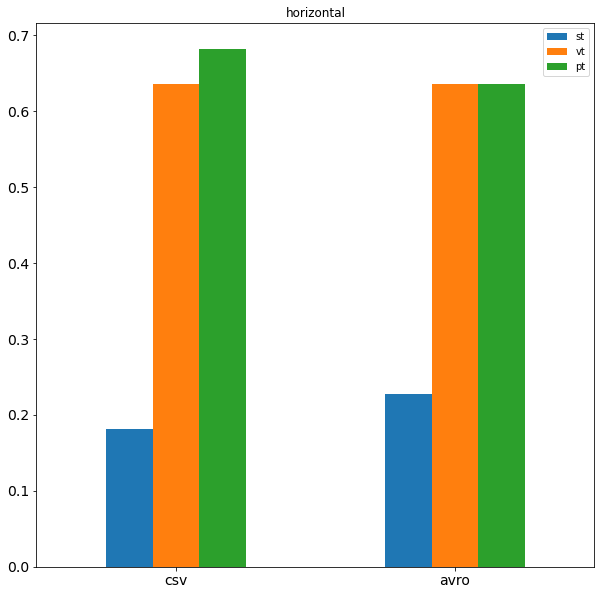

In [8]:
dim = 'schemas'
dataset = '100M'
opt = 'horizontal'  
SDRank.plot(dim, dataset, opt)

In [4]:
SDRank.plotRadar('partition', '100M')

In [ ]:
MDRankPareto.paretoAgg('100M', 'settings.yaml')

In [ ]:
MDRankPareto.paretoQ('100M', 'settings.yaml')

In [ ]:
MDRankPareto.plot('100M', 'settings.yaml')

In [2]:
conformance_set = ['schemas', 'partition','storage', 'paretoQ', 'paretoAgg']
Ranker.conformance(conformance_set,'100M', 'settings.yaml', 5, 15)

,100M
schemas,0.854545
partition,0.800000
storage,0.927273
paretoQ,0.818182
paretoAgg,0.927273


In [7]:
coherence_set = ['schemas', 'partition', 'storage', 'paretoQ', 'paretoAgg']
rank1 = '100M'
rank2 = '250M'
Ranker.coherence(coherence_set, rank1, rank2)

,Kendall's Index
schemas,0.464052
partition,0.477124
storage,0.522876
paretoQ,0.076923
paretoAgg,0.583333
